In [1]:
import copy, os, gc
import numpy as np
import pickle as pkl
from time import time, sleep
from tqdm import tqdm

from IPython import display
from collections import Counter
from itertools import product, chain, combinations


#matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

#https://matplotlib.org/users/customizing.html
matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.01
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
# Configuring latex fonts
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')


import sys
library_path = '../../../'
if library_path not in sys.path:
    sys.path.append(library_path)

CIFAR10_DIR = library_path + 'datasets/CIFAR10'
MNIST_DIR   = library_path + 'datasets/MNIST'

from ml.utils import get_CIFAR10_data, get_MNIST_data
from ml.neural_network import Layer, Sequential, Model, Solver
from ml.neural_network.layers import *
from ml.neural_network.nonlinearities import Tanh, ReLU, LeakyReLU, ELU, SoftPlus
from ml.neural_network.criterions import MSECriterion, MulticlassLogLoss
from ml.neural_network.regularizers import *
from ml.neural_network.initializers import *
from ml.neural_network.optimizers import *
from ml.neural_network.decorators import *
from ml.neural_network.gradients import *
from ml.neural_network.dataset import Dataset

In [2]:
def plot_solver_history(history, axarr=None, figsize=(10, 14), colors=None, markers=None, markersize=5,
                        only_loss=False):
    if axarr is None:
        _, axarr = plt.subplots(3, 1, figsize=figsize)
    plot_kwargs = {'markeredgecolor': 'k', 'ms': markersize, 'alpha': 0.7, 'zorder': 2}
    if colors is None:  colors = {'train': 'r', 'val': 'b'}
    if markers is None: markers = {'train': 'o', 'val': '^'}
        
    ax = axarr[0]  
    ax.plot(history['loss_history'], color=colors['train'], marker=markers['train'])
    ax.set_yscale('log')
    ax.set_xlabel('iteration')
    ax.set_ylabel('loss')
    ax.set_title('Training loss vs iteration')
    ax.grid(which='both', linestyle='--', alpha=0.5)

    ax = axarr[1]
    for label in ['train', 'val']:
        data = history['{}_loss_history'.format(label)]
        ax.plot(data, marker=markers[label], color=colors[label], label=label, **plot_kwargs)
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title('Loss vs epoch')
    ax.grid(which='both', linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=16)

    ax = axarr[2]
    for label in ['train', 'val']:
        data = history['{}_acc_history'.format(label)]
        ax.plot(data, marker=markers[label], color=colors[label], label=label, **plot_kwargs)
    ax.set_xlabel('epoch')
    ax.set_ylabel('training loss')
    ax.set_title('Accuracy vs epoch')
    ax.grid(which='both', linestyle='--', alpha=0.5)
    ax.legend(loc='lower right', fontsize=16)
    plt.tight_layout()
    plt.show()
    return axarr

In [4]:
n_lines = 0
for a in os.walk('../../../ml'): 
    for name in a[2]:
        if name.endswith('.py'):
            path = os.path.join(a[0], name)
            s = !wc -l {path}
            n = int(s.get_list()[0].split()[0])
            n_lines += n
            #print(n, path)
print(n_lines)

7523


<a id='cnn'></a>
# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

<a id='toc'></a>
# Table of Contents
* [1. Convolution](#cnn_conv)
    * [1.1 Convolution: Naive forward pass](#cnn_conv_forw)
    * [1.2 Aside: Image processing via convolutions](#cnn_conv_aside)
    * [1.3 Convolution: Naive backward pass](#cnn_conv_back)
* [2. Max pooling](#max_pooling)
    * [2.1 Max pooling: Naive forward](#cnn_max_pooling_forw)
    * [2.2 Max pooling: Naive backward](#cnn_max_pooling_back)
* [3. Fast layers](#cnn_fast)
* [4. Batch Normalization](#cnn_spatial)
    * [4.1 Batch normalization: forward](#cnn_spatial_forw)
    * [4.2 Batch normalization: backward](#cnn_spatial_back)
* [5. Three Layer ConvNet](#cnn_three)
    * [5.1 Sanity check loss](#cnn_three_sanity)
    * [5.2 Gradient check](#cnn_three_grad)
    * [5.3 Overfit small data](#cnn_three_overfit)
    * [5.4 Train net](#cnn_three_train)
    * [5.5 Visualize filters](#cnn_three_visualize)

In [5]:
data = get_CIFAR10_data(image_data_format='channels_first', cifar10_dir=CIFAR10_DIR, ordered=False,
                        ravel=False, substract_mean=True, random_state=1, normalize_by=255.0, verbose=True)
dataset = Dataset(data, random_state=123)

Training data shape:  (49000, 3, 32, 32)
Training labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)


<a id='cnn_conv'></a>
## 1. Convolution [[toc](#toc)]

<a id='cnn_conv_forw'></a>
### 1.1 Convolution: forward pass  [[toc](#toc)]
The core of a convolutional network is the convolution operation. In the file `ml/neural_network/cs231n/second/conv_layers_naive.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [6]:
X_batch, y_batch = dataset.get_batch(1)
print(X_batch.shape, y_batch.shape)

for method in ['naive', 'corr', 'fast']:
    print('FORWARD PROPAGATION FOR {}'.format(method.upper()))
    conv = Convolution(n_filters=10, kernel_size=(5, 5), stride=(2, 2), method=method)
    conv.initialize({'input_shape': X_batch.shape})
    output = conv.forward(X_batch)
    print('output.shape      :', output.shape)
    print(output[0, 0, :2, :2])
    print('BACKWARD PROPAGATION FOR {}'.format(method.upper()))
    np.random.seed(1)
    grad_output = np.random.rand(*output.shape)
    grad_input = conv.backward(X_batch, grad_output)
    print('grad_output.shape :', grad_output.shape)
    print(grad_output[0, 0, :2, :2])
    print()

(1, 3, 32, 32) (1,)
FORWARD PROPAGATION FOR NAIVE
output.shape      : (1, 10, 15, 15)
[[0.23753124 0.2518426 ]
 [0.27075334 0.35245521]]
BACKWARD PROPAGATION FOR NAIVE
grad_output.shape : (1, 10, 15, 15)
[[0.417022   0.72032449]
 [0.67046751 0.4173048 ]]

FORWARD PROPAGATION FOR CORR
output.shape      : (1, 10, 15, 15)
[[0.23753124 0.2518426 ]
 [0.27075334 0.35245521]]
BACKWARD PROPAGATION FOR CORR
grad_output.shape : (1, 10, 15, 15)
[[0.417022   0.72032449]
 [0.67046751 0.4173048 ]]

FORWARD PROPAGATION FOR FAST
output.shape      : (1, 10, 15, 15)
[[0.23753124 0.2518426 ]
 [0.27075334 0.35245521]]
BACKWARD PROPAGATION FOR FAST
grad_output.shape : (1, 10, 15, 15)
[[0.417022   0.72032449]
 [0.67046751 0.4173048 ]]



In [7]:
n_samples = 2; n_channels = 3; n_filters = 3
X_shape = (n_samples, n_channels, 4, 4)
W_shape = (n_filters, n_channels, 4, 4)
X = np.linspace(-0.1, 0.5, num=np.prod(X_shape)).reshape(X_shape)
W = np.linspace(-0.2, 0.3, num=np.prod(W_shape)).reshape(W_shape)
b = np.linspace(-0.1, 0.2, num=3)
for method in ['naive', 'corr', 'fast']:
    print('Considering method "{}"'.format(method))
    conv = Convolution(n_filters=3, kernel_size=(4, 4), stride=2, padding=1, W_init=W, b_init=b, method=method)
    conv.initialize({'input_shape': X.shape})
    out = conv.forward(X)
    correct_out = np.array([[[[-0.08759809, -0.10987781],
                               [-0.18387192, -0.2109216 ]],
                              [[ 0.21027089,  0.21661097],
                               [ 0.22847626,  0.23004637]],
                              [[ 0.50813986,  0.54309974],
                               [ 0.64082444,  0.67101435]]],
                             [[[-0.98053589, -1.03143541],
                               [-1.19128892, -1.24695841]],
                              [[ 0.69108355,  0.66880383],
                               [ 0.59480972,  0.56776003]],
                              [[ 2.36270298,  2.36904306],
                               [ 2.38090835,  2.38247847]]]])

    # Compare your output to ours; difference should be around 2e-8
    print('\tdifference: ', rel_error(out, correct_out))

Considering method "naive"
	difference:  2.2121476417505994e-08
Considering method "corr"
	difference:  2.2121476417505994e-08
Considering method "fast"
	difference:  2.2121476575931688e-08


<a id='cnn_conv_aside'></a>
### 1.2 Aside: Image processing via convolutions [[toc](#toc)]
As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check. 

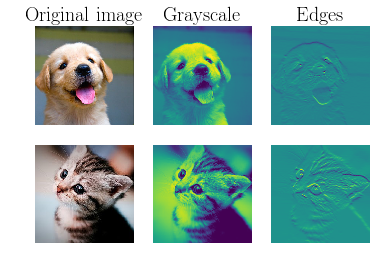

In [9]:
from skimage.io import imread
from skimage.transform import resize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
X = np.zeros((2, 3, img_size, img_size))
X[0, :, :, :] = resize(puppy, (img_size, img_size), mode='reflect').transpose((2, 0, 1))
X[1, :, :, :] = resize(kitten_cropped, (img_size, img_size), mode='reflect').transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
W = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
W[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
W[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
W[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
W[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
conv = Convolution(2, kernel_size=(3, 3), stride=1, padding=1, W_init=W, b_init=b, method='corr')
conv.initialize({'input_shape': X.shape})
out = conv.forward(X)

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

<a id='cnn_conv_back'></a>
### 1.3 Convolution: Naive backward pass [[toc](#toc)]
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [8]:
# Your errors should be around 1e-8'
np.random.seed(231)
n_samples = 4; n_channels = 3; input_h = input_w = 5
n_filters = 2; filter_h = filter_w = 3
X = np.random.randn(n_samples, n_channels, input_h, input_w)
W = np.random.randn(n_filters, n_channels, filter_h, filter_w)
b = np.random.randn(n_filters,)
grad_Y = np.random.randn(n_samples, n_filters, 5, 5)
grad_checker = GradientsChecker()
for method in ['naive', 'corr', 'fast']:
    print('Considering method "{}"'.format(method))
    conv = Convolution(n_filters=n_filters, kernel_size=(filter_h, filter_w), stride=1, padding=1,
                       W_init=W, b_init=b, method=method)
    conv.initialize({'input_shape': X.shape})
    grad_checker.eval_gradients(conv, X, grad_Y)
    print()

Considering method "naive"
grad_Convolution0:W error = 2.247109434939654e-10
grad_Convolution0:b error = 3.3726153958780465e-11
grad_X error = 1.159803161159293e-08

Considering method "corr"
grad_Convolution0:W error = 3.7332016776656607e-10
grad_Convolution0:b error = 1.1987307048126593e-10
grad_X error = 8.313436777798198e-09

Considering method "fast"
grad_Convolution0:W error = 2.6782731187123837e-10
grad_Convolution0:b error = 3.8835192329918934e-11
grad_X error = 7.990141425370759e-09



In [9]:
np.random.seed(100)
n_samples = 1
n_channels = 3; n_filters = 3
input_h = 400; input_w = 400
filter_h = filter_w = 10
stride = 1; padding = (1, 0)
output_h = (input_h + padding[0] + padding[1] - filter_h) // stride + 1
output_w = (input_w + padding[0] + padding[1] - filter_w) // stride + 1
X      = np.random.randn(n_samples, n_channels, input_h, input_w)
grad_Y = np.random.randn(n_samples, n_filters, output_h, output_w)

for method in ['corr', 'fast']:
    print('Considering method "{}"'.format(method))
    conv = Convolution(n_filters=n_filters, kernel_size=(filter_h, filter_w), stride=stride, padding=padding,
                       method=method)
    conv.initialize({'input_shape': (-1, n_channels, input_h, input_w), 'seed': 1})
    t1 = time()
    conv.forward(X)
    conv.backward(X, grad_Y)
    t2 = time()
    print('time = {}'.format(t2 - t1))

Considering method "corr"
time = 0.7969319820404053
Considering method "fast"
time = 0.34328126907348633


<a id='cnn_max_pooling'></a>
## 2. Max pooling [[toc](#toc)]

<a id='cnn_max_pooling_forw'></a>
### 2.1 Max pooling: Naive forward  [[toc](#toc)]
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [4]:
n_samples = 2; n_channels = 3; input_h = input_w = 4
input_shape = (n_samples, n_channels, input_h, input_w)
input = np.linspace(-0.3, 0.4, num=np.prod(input_shape)).reshape(input_shape)
max_pool = MaxPooling(kernel_size=(2, 2), stride=2, method='fast')
print(max_pool.initialize({'input_shape': input.shape}))
out = max_pool.forward(input)
correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

{'debug': False, 'grad_clip': inf, 'dtype': <class 'numpy.float64'>, 'input_shape': (-1, 3, 2, 2), 'names': {'MaxPooling': 1}, 'seed': 1}
Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


<a id='cnn_max_pooling_back'></a>
### 2.2 Max pooling: Naive backward [[toc](#toc)]
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [5]:
# Your error should be around 1e-12
np.random.seed(232)
n_samples = 3; n_channels = 2; input_h = input_w = 8
n_filters = 2
input = np.random.randn(n_samples, n_channels, input_h, input_w)
grad_output = np.random.randn(n_samples, n_filters, 4, 4)
max_pool = MaxPooling(kernel_size=(2, 2), stride=2, method='fast')
print(max_pool.initialize({'input_shape': input.shape}))
grad_checker = GradientsChecker(verbose=True)
grad_checker.eval_gradients(max_pool, input, grad_output)

{'debug': False, 'grad_clip': inf, 'dtype': <class 'numpy.float64'>, 'input_shape': (-1, 2, 4, 4), 'names': {'MaxPooling': 1}, 'seed': 1}
grad_X error = 3.2756158125805727e-12


<a id='cnn_fast'></a>
## 3. Fast layers [[toc](#toc)]
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [12]:
from time import time
np.random.seed(231)
n_filters = 25
X = np.random.randn(100, 3, 31, 31)
W = np.random.randn(n_filters, 3, 3, 3)
b = np.random.randn(n_filters,)
grad_Y = np.random.randn(100, n_filters, 16, 16)

conv_naive = Convolution(n_filters, (3, 3), stride=2, padding=1, method='naive',
                  W_init=W, b_init=b)
conv_naive.initialize({'input_shape': X.shape})

conv_corr = Convolution(n_filters, (3, 3), stride=2, padding=1, method='corr',
                  W_init=W, b_init=b)
conv_corr.initialize({'input_shape': X.shape})

conv_fast = Convolution(n_filters, (3, 3), stride=2, padding=1, method='fast',
                  W_init=W, b_init=b)
conv_fast.initialize({'input_shape': X.shape})


t0 = time()
out_naive = conv_naive.forward(X)
t1 = time()
out_corr  = conv_corr.forward(X)
t2 = time()
out_fast  = conv_fast.forward(X)
t3 = time()

print('Testing conv forward fast:')
print('Naive: %fs' % (t1 - t0))
print('Corr: %fs' % (t2 - t1))
print('Fast: %fs' % (t3 - t2))
print('Speedup naive/fast: %fx' % ((t1 - t0) / (t3 - t2)))
print('Speedup corr/fast : %fx' % ((t2 - t1) / (t3 - t2)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
grad_X_naive = conv_naive.backward(X, grad_Y)
grad_W_naive = conv_naive.grad_W
grad_b_naive = conv_naive.grad_b
t1 = time()
grad_X_corr = conv_corr.backward(X, grad_Y)
grad_W_corr = conv_corr.grad_W
grad_b_corr = conv_corr.grad_b
t2 = time()
grad_X_fast = conv_fast.backward(X, grad_Y)
grad_W_fast = conv_fast.grad_W
grad_b_fast = conv_fast.grad_b
t3 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Corr: %fs' % (t2 - t1))
print('Fast: %fs' % (t3 - t2))
print('Speedup naive/fast: %fx' % ((t1 - t0) / (t3 - t2)))
print('Speedup corr/fast : %fx' % ((t2 - t1) / (t3 - t2)))
print('grad_X difference: ', rel_error(grad_X_naive, grad_X_fast), rel_error(grad_X_corr, grad_X_fast))
print('grad_W difference: ', rel_error(grad_W_naive, grad_W_fast), rel_error(grad_W_corr, grad_W_fast))
print('grad_b difference: ', rel_error(grad_b_naive, grad_b_fast), rel_error(grad_b_corr, grad_b_fast))

Testing conv forward fast:
Naive: 0.235265s
Corr: 0.706875s
Fast: 0.007220s
Speedup naive/fast: 32.586124x
Speedup corr/fast : 97.907998x
Difference:  4.926407851494105e-11

Testing conv_backward_fast:
Naive: 7.903534s
Corr: 0.469684s
Fast: 0.006675s
Speedup naive/fast: 1183.964534x
Speedup corr/fast : 70.359620x
grad_X difference:  3.0189906199222895e-11 1.4465996720233507e-11
grad_W difference:  2.2471943429694198e-13 7.132066100400784e-14
grad_b difference:  3.1393858025571252e-15 5.8302879190347134e-15


In [6]:
np.random.seed(231)
X = np.random.randn(100, 3, 32, 32)
grad_Y = np.random.randn(100, 3, 16, 16)

pool_naive = MaxPooling((2, 2), stride=2, method='naive')
pool_naive.initialize({'input_shape': X.shape})
pool_fast = MaxPooling((2, 2), stride=2, method='fast')
pool_fast.initialize({'input_shape': X.shape})

t0 = time()
out_naive = pool_naive.forward(X)
t1 = time()
out_fast = pool_fast.forward(X)
t2 = time()

print('Testing conv forward fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup naive/fast: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
grad_X_naive = pool_naive.backward(X, grad_Y)
t1 = time()
grad_X_fast = pool_fast.backward(X, grad_Y)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup naive/fast: %fx' % ((t1 - t0) / (t2 - t1)))
print('grad_X difference: ', rel_error(grad_X_naive, grad_X_fast))

Testing conv forward fast:
Naive: 0.456750s
Fast: 0.001538s
Speedup naive/fast: 296.969152x
Difference:  0.0

Testing conv_backward_fast:
Naive: 0.349746s
Fast: 0.009004s
Speedup naive/fast: 38.841899x
grad_X difference:  0.0


<a id='cnn_spatial'></a>
## 4. Spatial Batch Normalization [[toc](#toc)]
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

<a id='cnn_spatial_forw'></a>
### 4.1 Batch normalization: forward [[toc](#toc)]

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [8]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
X = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', X.shape)
print('  Means: ', X.mean(axis=(0, 2, 3)))
print('  Stds: ', X.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn = BatchNormalization()
bn.initialize({'input_shape': X.shape})
bn.gamma = gamma; bn.beta = beta
out = bn.forward(X)

print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ',  out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
bn.gamma = gamma; bn.beta = beta
out = bn.forward(X)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ',  out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [9]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn = BatchNormalization()
bn.initialize({'input_shape': (N, C, H, W)})
bn.train()
for t in range(50):
    X = 2.3 * np.random.randn(N, C, H, W) + 13
    bn.forward(X)

bn.evaluate()
X = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm = bn.forward(X)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ',  a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


<a id='cnn_spatial_back'></a>
### 4.2 Batch normalization: backward [[toc](#toc)]
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [10]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
X = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn = BatchNormalization()
bn.initialize({'input_shape': (N, C, H, W)})
bn.train()

grad_checker = GradientsChecker()
grad_checker.eval_gradients(bn)

grad_BatchNormalization0:gamma error = 1.8246042271044925e-11
grad_BatchNormalization0:beta error = 5.80633620907433e-12
grad_X error = 1.9921105304167864e-08


<a id='cnn_three'></a>
## 5. Three-layer ConvNet  [[toc](#toc)]
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

In [39]:
def make_three_layer_cnn(n_filters=32, filter_size=7, conv_stride=1, conv_padding=None,
                        pool_size=2, pool_stride=2,
                        hidden_size=100, n_classes=10,
                        l2_reg=0.0, dropout=0.0,
                        use_batchnorm=False, 
                        W1_init=None, b1_init=None, 
                        W2_init=None, b2_init=None,
                        W3_init=None, b3_init=None, method='C'):
    W_reg = None
    use_dropout = False
    if l2_reg > 0:
        W_reg = L2Regularizer(l2_reg)
    if dropout > 0:
        use_dropout = True
    layers = []
    conv_method = 'fast'
    pool_method = 'fast'
    if method == 'python':
        conv_method = 'corr'
        pool_method = 'naive'
    if conv_padding is None:
        conv_padding = (filter_size - 1) // 2
    layers.append(Convolution(n_filters=n_filters, kernel_size=filter_size, stride=conv_stride, 
                              padding=conv_padding, W_reg=W_reg, W_init=W1_init, b_init=b1_init, method=conv_method))
    if use_batchnorm:
        layers.append(BatchNormalization(eps=1e-8))
    layers.append(ReLU())
    layers.append(MaxPooling(kernel_size=pool_size, stride=pool_stride, method=pool_method))  
    if use_dropout:
        layers.append(Dropout(dropout))
    layers.append(Flatten())
    layers.append(Dense(hidden_size, W_reg=W_reg, W_init=W2_init, b_init=b2_init))
    layers.append(ReLU())
    if use_dropout:
        layers.append(Dropout(dropout))
    layers.append(Dense(n_classes, W_reg=W_reg, W_init=W3_init, b_init=b3_init))
    layers.append(SoftMax())
    return Model(layers, MulticlassLogLoss())

<a id='cnn_three_sanity'></a>
### 5.1 Sanity check loss [[toc](#toc)]
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [41]:
N = 50
np.random.seed(231)
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

model = make_three_layer_cnn(use_batchnorm=True)
model.compile(input_shape=X.shape)
print(model)
loss = model.forward(X, y)
print('Initial loss (no regularization): ', loss)

model = make_three_layer_cnn(l2_reg=0.5)
model.compile(input_shape=X.shape)
print(model)
loss = model.forward(X, y)
print('Initial loss (with regularization): ', loss)

Convolution((3, 32, 32)->(32, 32, 32))->BatchNormalization->ReLU->MaxPooling((32, 32, 32)->(32, 16, 16))->Flatten->Dense(8192->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
Initial loss (no regularization):  2.623200942606969
Convolution((3, 32, 32)->(32, 32, 32))->ReLU->MaxPooling((32, 32, 32)->(32, 16, 16))->Flatten->Dense(8192->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
Initial loss (with regularization):  38.052912332140224


<a id='cnn_three_grad'></a>
### 5.2 Gradient check [[toc](#toc)]
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to 1e-2.

In [43]:
n_samples = 2
input_dim = (3, 16, 16)
l2_reg = 0.5; use_batchnorm=True; dropout=0.0; method='fast'
n_classes = 10
np.random.seed(231)
X = np.random.randn(n_samples, *input_dim)
y = np.random.randint(n_classes, size=n_samples)

model = make_three_layer_cnn(n_filters=3, filter_size=3, hidden_size=7, 
                             l2_reg=l2_reg, use_batchnorm=use_batchnorm, dropout=dropout, method=method)
model.compile(input_shape=X.shape)
print('loss before check:', model.forward(X, y))
print(model)
grad_checker = GradientsChecker(step=1e-6)
grad_checker.eval_gradients(model)
print('loss after check:', model.forward(X, y))

loss before check: 8.086742348864504
Convolution((3, 16, 16)->(3, 16, 16))->BatchNormalization->ReLU->MaxPooling((3, 16, 16)->(3, 8, 8))->Flatten->Dense(192->7)->ReLU->Dense(7->10)->SoftMax->[MulticlassLogLoss]
grad_Convolution0:W error = 2.5002098926637067e-08
grad_Convolution0:b error = 4.176888869500406e-05
grad_BatchNormalization0:gamma error = 1.6202136907373546e-09
grad_BatchNormalization0:beta error = 2.4694430471466e-09
grad_Dense0:W error = 8.144840958003312e-07
grad_Dense0:b error = 1.4654845706240571e-08
grad_Dense1:W error = 2.2917052084130397e-07
grad_Dense1:b error = 1.7202494908418434e-08
loss after check: 8.086742348864504


<a id='cnn_three_overfit'></a>
### 5.3 Overfit small data [[toc](#toc)]
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [44]:
small_dataset = dataset.get_small_train_dataset(100)
model = make_three_layer_cnn()
solver = Solver(model, small_dataset,
                n_epochs=15, batch_size=50,
                optim_config={
                    'update_rule': 'adam',
                    'learning_rate': 3e-3,
                    'learning_rate_decay': 0.99
                },
                verbose=False, 
                print_every_epoch=1, seed=2)
print(model)
model = solver.train()

Convolution((3, 32, 32)->(32, 32, 32))->ReLU->MaxPooling((32, 32, 32)->(32, 16, 16))->Flatten->Dense(8192->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/15) train acc: 0.22; val acc: 0.12, train loss: 3.265; val loss: 4.549
(Epoch 2/15) train acc: 0.28; val acc: 0.14, train loss: 2.104; val loss: 2.934
(Epoch 3/15) train acc: 0.31; val acc: 0.11, train loss: 1.914; val loss: 2.38
(Epoch 4/15) train acc: 0.37; val acc: 0.1, train loss: 1.785; val loss: 2.295
(Epoch 5/15) train acc: 0.49; val acc: 0.12, train loss: 1.569; val loss: 2.273
(Epoch 6/15) train acc: 0.59; val acc: 0.17, train loss: 1.359; val loss: 2.324
(Epoch 7/15) train acc: 0.61; val acc: 0.18, train loss: 1.248; val loss: 2.536
(Epoch 8/15) train acc: 0.72; val acc: 0.21, train loss: 1.054; val loss: 2.555
(Epoch 9/15) train acc: 0.7; val acc: 0.21, train loss: 0.9829; val loss: 2.728
(Epoch 10/15) train acc: 0.74; val acc: 0.22, train loss: 0.8419; val loss: 2.863
(Epoch 11/15) train acc: 0.79; val a

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

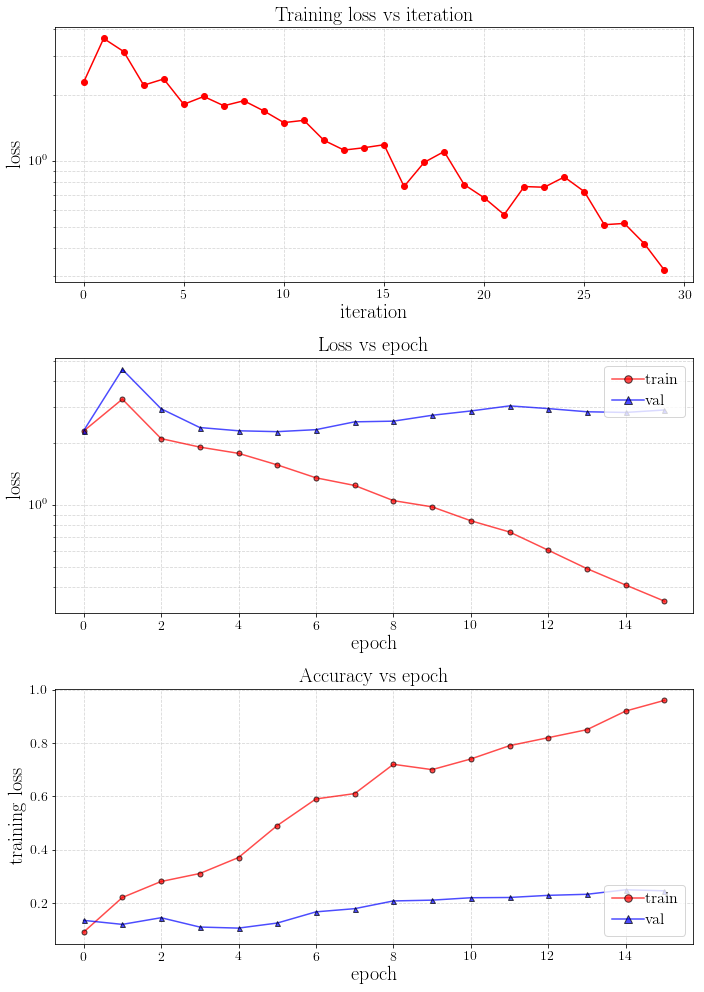

In [47]:
plot_solver_history(solver.history);

<a id='cnn_three_train'></a>
### 5.4 Train net [[toc](#toc)]
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [49]:
weight_scale = 0.001; random_state = 0
generator = np.random.RandomState(random_state)
W1_init = generator.normal(scale=weight_scale, size=(32, 3, 7, 7))
W2_init = generator.normal(scale=weight_scale, size=(8192, 500))
W3_init = generator.normal(scale=weight_scale, size=(500, 10))

model = make_three_layer_cnn(hidden_size=500, dropout=0.0, l2_reg=0.001, use_batchnorm=True, 
                             W1_init=W1_init, W2_init=W2_init, W3_init=W3_init)
solver = Solver(model, dataset,
                n_epochs=1, batch_size=50,
                optim_config={
                    'update_rule': 'adam',
                    'learning_rate': 1e-3,
                    'learning_rate_decay': 0.99
                },
                verbose=False, print_every_epoch=None, print_every_iter=20, seed=2, 
                update_history=True)
print(model)
model = solver.train()

Convolution((3, 32, 32)->(32, 32, 32))->BatchNormalization->ReLU->MaxPooling((32, 32, 32)->(32, 16, 16))->Flatten->Dense(8192->500)->ReLU->Dense(500->10)->SoftMax->[MulticlassLogLoss]
(Iteration 20/980) loss: 2.0649865966350753
(Iteration 40/980) loss: 2.0461446060234776
(Iteration 60/980) loss: 1.6289843855918973
(Iteration 80/980) loss: 1.8618849765002548
(Iteration 100/980) loss: 1.8723355718635413
(Iteration 120/980) loss: 1.560329222872957
(Iteration 140/980) loss: 1.7799017855752532
(Iteration 160/980) loss: 1.5015717889158715
(Iteration 180/980) loss: 1.6989222239609805
(Iteration 200/980) loss: 1.7768375126923126
(Iteration 220/980) loss: 1.5936942275712247
(Iteration 240/980) loss: 1.74965695231832
(Iteration 260/980) loss: 1.702988901068855
(Iteration 280/980) loss: 1.5204608875461376
(Iteration 300/980) loss: 1.8320322086009857
(Iteration 320/980) loss: 1.4554366198950173
(Iteration 340/980) loss: 1.5169719518428066
(Iteration 360/980) loss: 1.6677909884290723
(Iteration 380

In [50]:
probas = model.forward(data['X_val'])
y_pred = np.argmax(probas, axis=1)
y_true = data['y_val']
print('Validation accuracy:', np.mean(y_pred == y_true))

Validation accuracy: 0.511


<a id='cnn_three_visualize'></a>
### 5.5 Visualize filters [[toc](#toc)]
You can visualize the first-layer convolutional filters from the trained network by running the following:

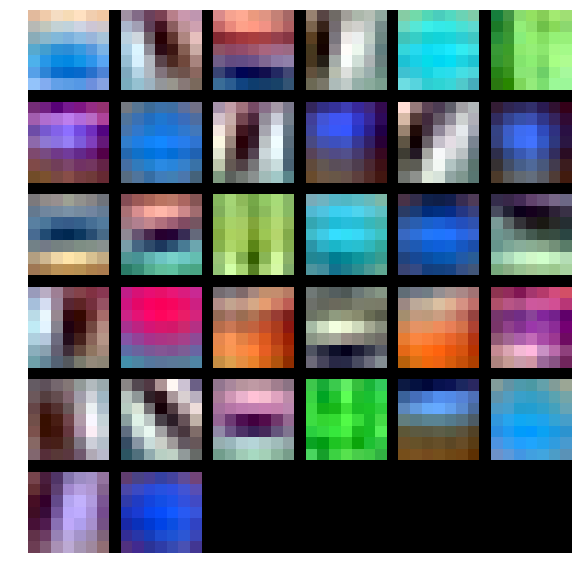

In [51]:
from ml.utils.vis_utils import visualize_grid
grid = visualize_grid(model[0].W.transpose(0, 2, 3, 1), n_cols=6)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()

## Extra Credit Description [[toc](#toc)]
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.